<a href="https://colab.research.google.com/github/pooja251096/Book-Recommendation-System/blob/main/Book_RS_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color='blue'>**BOOK RECOMMENDATION SYSTEM**

#<font color='blue'>**Problem Statement**
<font color='blue'>
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such
web services, recommender systems have taken more and more place in our lives. From
e-commerce (suggest to buyers articles that could interest them) to online advertisement
(suggest to users the right contents, matching their preferences), recommender systems are
today unavoidable in our daily online journeys.
<br>
In a very general way, recommender systems are algorithms aimed at suggesting relevant
items to users (items being movies to watch, text to read, products to buy, or anything else
depending on industries).<br>
Recommender systems are really critical in some industries as they can generate a huge
amount of income when they are efficient or also be a way to stand out significantly from
competitors. The main objective is to create a book recommendation system for users.

#<font color='blue'>**The Data**
<font color='blue'>
The Book-Crossing dataset comprises 3 files.<br>
● Users :<br>
Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these
fields contain NULL values.<br>
● Books : <br>
Books are identified by their respective ISBN. Invalid ISBNs have already been removed
from the dataset. Moreover, some content-based information is given (Book-Title,
Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web
Services. Note that in the case of several authors, only the first is provided. URLs linking
to cover images are also given, appearing in three different flavors (Image-URL-S,
Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.<br>
● Ratings :<br> 
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,
expressed by 0.

In [2]:
#Importing modules
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import random

import re
import pickle
import operator
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<b><h3>Dataset

In [4]:
books = pd.read_csv(r"/content/gdrive/MyDrive/Clustering/Books.csv", sep = ',', header = 'infer', index_col = None)
users = pd.read_csv(r"/content/gdrive/MyDrive/Clustering/Users.csv", sep = ',', header = 'infer', index_col = None)
ratings = pd.read_csv(r"/content/gdrive/MyDrive/Clustering/Ratings.csv", sep = ',', header = 'infer', index_col = None)

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


<b><h3>Pre-processing

In [5]:
## Checking for null values
books.isnull().sum() 

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [6]:
#dropping last three columns containing image URLs which will not be required for analysis
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

In [7]:
#exploring 'Book-Author' column
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [8]:
#Filling Nan of Book-Author with others
books['Book-Author'].fillna('other',inplace=True)

In [9]:
#exploring 'publisher' column
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [10]:
#Filling Nan of Publisher with others
books.Publisher.fillna('other',inplace=True)

In [11]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [12]:
books['Year-Of-Publication']=books['Year-Of-Publication'].astype('str')
a=list(books['Year-Of-Publication'].unique())
a=set(a)
a=list(a)
a = [x for x in a if x is not None]
a.sort()
print(a)

['0', '1376', '1378', '1806', '1897', '1900', '1901', '1902', '1904', '1906', '1908', '1909', '1910', '1911', '1914', '1917', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2012', '2020', '2021', '2024', '2026', '2030', '2037', '2038', '2050', 'DK Publishing Inc', 'Gallimard']


In [13]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


<font color='blue'>As it can be seen from above that there are some incorrect entries in Year-Of-Publication field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as Year-Of-Publication in dataset due to some errors in csv file 

In [14]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '0789466953','Book-Author'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#rechecking
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]
#corrections done

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


In [15]:
#investigating the rows having 'Gallimard' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [16]:
#making required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','Year-Of-Publication'] = 2003
books.loc[books.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','Publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"


books.loc[books.ISBN == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [17]:
books['Year-Of-Publication']=pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

print(sorted(books['Year-Of-Publication'].unique()))
#Now it can be seen that yearOfPublication has all values as integers

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


<font color='blue'>The value 0 for Year-Of_Publication is invalid and as this dataset was published in 2004, We have assumed that the years after 2006 to be 
invalid and setting invalid years as NaN

Reference of the fact: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

In [18]:
books.loc[(books['Year-Of-Publication'] > 2006) | (books['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN

#replacing NaNs with median value of Year-Of-Publication
books['Year-Of-Publication'].fillna(round(books['Year-Of-Publication'].median()), inplace=True)

In [19]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [20]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [21]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [22]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271047 non-null  object 
 1   Book-Title           271047 non-null  object 
 2   Book-Author          271047 non-null  object 
 3   Year-Of-Publication  271047 non-null  float64
 4   Publisher            271047 non-null  object 
dtypes: float64(1), object(4)
memory usage: 10.3+ MB


<b>Users Dataset Pre-processing

In [23]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [24]:
## Checking null values
print(users.isna().sum())               

User-ID          0
Location         0
Age         110762
dtype: int64


In [25]:
def missing_values(df):
    mis_val=df.isnull().sum()
    mis_val_percent=round(df.isnull().mean().mul(100),2)
    mz_table=pd.concat([mis_val,mis_val_percent],axis=1)
    mz_table=mz_table.rename(
    columns={df.index.name:'col_name',0:'Missing Values',1:'% of Total Values'})
    mz_table['Data_type']=df.dtypes
    mz_table=mz_table.sort_values('% of Total Values',ascending=False)
    return mz_table.reset_index()

In [26]:
missing_values(users)

,index,Missing Values,% of Total Values,Data_type
0,Age,110762,39.72,float64
1,User-ID,0,0.00,int64
2,Location,0,0.00,object


<font color='blue'>Age have around 39% missing values. 

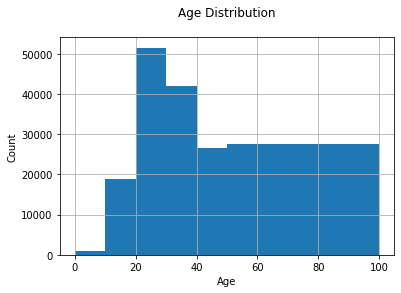

In [27]:
#Age Distribution
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<font color='blue'>The most active users are among those in their 20–30s.

Text(0.5, 1.0, 'Find outlier data in Age column')

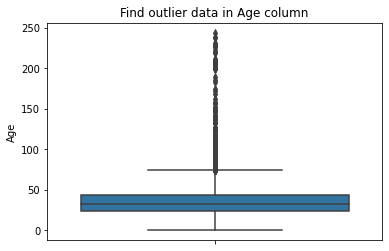

In [28]:
#Let's check for outliers in age column
sns.boxplot(y='Age', data=users)
plt.title('Find outlier data in Age column')

In [29]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

<font color='blue'>Age : 244 <br>
Ok we have Outlier data in Age

In [30]:
#Let's find our unique value in Location column
users.Location.unique()

array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

In [31]:
users.Location.nunique()

57339





<font color='blue'>57339 unique Value it's really hard to understand<br>
So lets create column Country

In [32]:
for i in users:
    users['Country']=users.Location.str.extract(r'\,+\s?(\w*\s?\w*)\"*$')   

In [33]:
users.Country.nunique()

529

In [34]:
#drop location column
users.drop('Location',axis=1,inplace=True)

In [35]:
users.head(2)

,User-ID,Age,Country
0,1,NaN,usa
1,2,18.0,usa


In [36]:

users.isnull().sum()

User-ID         0
Age        110762
Country       368
dtype: int64

In [37]:
users['Country']=users['Country'].astype('str')

In [38]:
a=list(users.Country.unique())
a=set(a)
a=list(a)
a = [x for x in a if x is not None]
a.sort()
print(a)

['', '01776', '02458', '19104', '23232', '30064', '85021', '87510', '_ brasil', 'a', 'aaa', 'adsgfdr', 'afghanistan', 'ahrensburg', 'alachua', 'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra', 'america', 'american samoa', 'andorra', 'angola', 'antarctica', 'aotearoa', 'argentina', 'armenia', 'aroostook', 'aruba', 'asturies', 'auckland', 'austbritania', 'australia', 'australii', 'austria', 'autralia', 'az', 'azerbaijan', 'bademn würtemberg', 'bahamas', 'bahrain', 'baltimore', 'bangladesh', 'barbados', 'basilicata', 'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus', 'belgi', 'belgique', 'belgium', 'belize', 'bell', 'benin', 'berguedà', 'bermuda', 'bernalillo', 'bfe', 'bhutan', 'bih', 'bkk', 'bladen', 'bolivia', 'bosnia', 'botswana', 'brasil', 'brazil', 'brunei', 'brunei darussalam', 'bucks', 'bulgaria', 'buncombe', 'burkina faso', 'burkinafasu', 'burlington', 'burma', 'butler', 'c', 'cadd0', 'calabria', 'california', 'cambodia', 'camden', 'cameroon', 'can', 'c

In [39]:
#Some data has Misspellings Let's correct it.
users['Country'].replace(['','01776','02458','19104','23232','30064','85021','87510','alachua','america','austria','autralia','cananda','geermany','italia','united kindgonm','united sates','united staes','united state','united states','us'],
                           ['other','usa','usa','usa','usa','usa','usa','usa','usa','usa','australia','australia','canada','germany','italy','united kingdom','usa','usa','usa','usa','usa'],inplace=True)

Text(0.5, 1.0, 'Count of users Country wise')

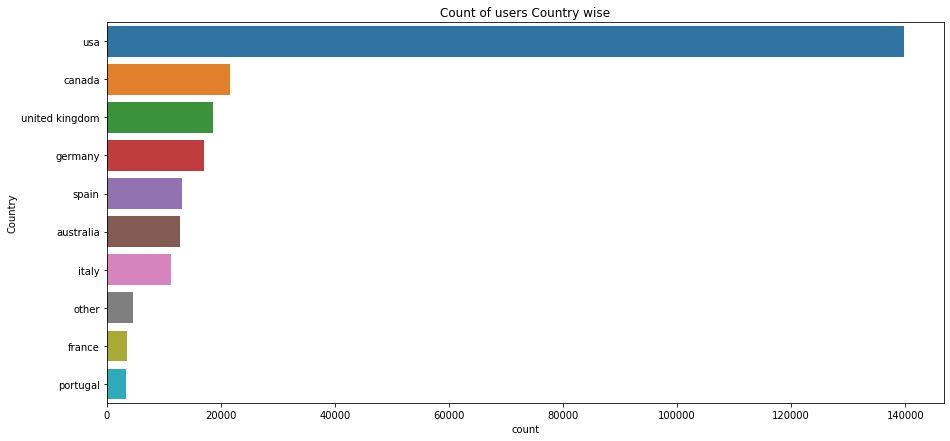

In [40]:


plt.figure(figsize=(15,7))
sns.countplot(y='Country',data=users,order=pd.value_counts(users['Country']).iloc[:10].index)
plt.title('Count of users Country wise')

Most number of users are from USA

<font color='blue'>Let's treat outliers in users age

Text(0.5, 1.0, 'Age Distribution Plot')

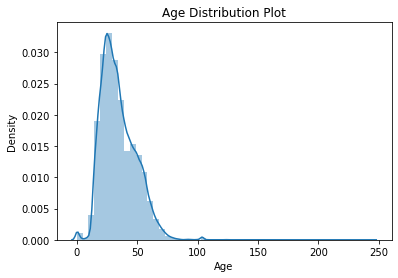

In [41]:
sns.distplot(users.Age)
plt.title('Age Distribution Plot')

<font color='blue'>Age value's below 5 and above 100 do not make much sense for our book rating case...hence replacing these by NaNs

In [42]:
# outlier data became NaN
users.loc[(users.Age > 100) | (users.Age < 5), 'Age'] = np.nan

<font color='blue'>Age has positive Skewness (right tail)
so we can use median to fill Nan values,
but for this we don't like to fill Nan value just for one range of age. To handle this we'll use country column to fill Nan.

In [43]:
users['Age'] = users['Age'].fillna(users.groupby('Country')['Age'].transform('median'))

In [44]:
users.isna().sum()

User-ID      0
Age        276
Country      0
dtype: int64

<font color='blue'>Still we have 276 Nan values let's fill them with mean

In [45]:
users['Age'].fillna(users.Age.mean(),inplace=True)

In [46]:
users.isna().sum()

User-ID    0
Age        0
Country    0
dtype: int64

In [47]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [48]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   User-ID  278858 non-null  int64  
 1   Age      278858 non-null  float64
 2   Country  278858 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


<b>Books-Ratings Dataset Pre-processing

In [49]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [50]:
## Checking for null values
ratings.isnull().sum() 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

<font color='blue'>Ratings dataset should have books only which exist in our books dataset


In [51]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings.shape,ratings_new.shape

((1149780, 3), (1030617, 3))

<font color='blue'>It can be seen that many rows having book ISBN not part of books dataset got dropped off

<font color='blue'>Ratings dataset should have ratings from users which exist in users dataset.

In [52]:
print("Shape of dataset before dropping",ratings_new.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (1030617, 3)
shape of dataset after dropping (1030617, 3)


<font color='blue'>It can be seen that no new user was there in ratings dataset.

<font color='blue'>Let's see how the ratings are distributed

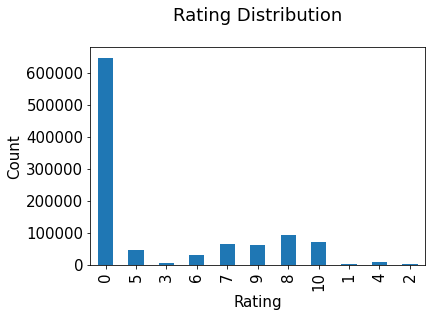

In [53]:

plt.rc("font", size=15)
ratings_new['Book-Rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

<font color='blue'>The ratings are very unevenly distributed, and the vast majority of ratings are 0 .As quoted in the description of the dataset - BX-Book-Ratings contains the book rating information. Ratings are either explicit, expressed on a scale from 1-10 higher values denoting higher appreciation, or implicit, expressed by 0.Hence segragating implicit and explict ratings datasets

In [54]:

#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

In [55]:
print('ratings_explicit dataset shape',ratings_explicit.shape)
print('ratings_implicit dataset',ratings_implicit.shape)

ratings_explicit dataset shape (383643, 3)
ratings_implicit dataset (646974, 3)


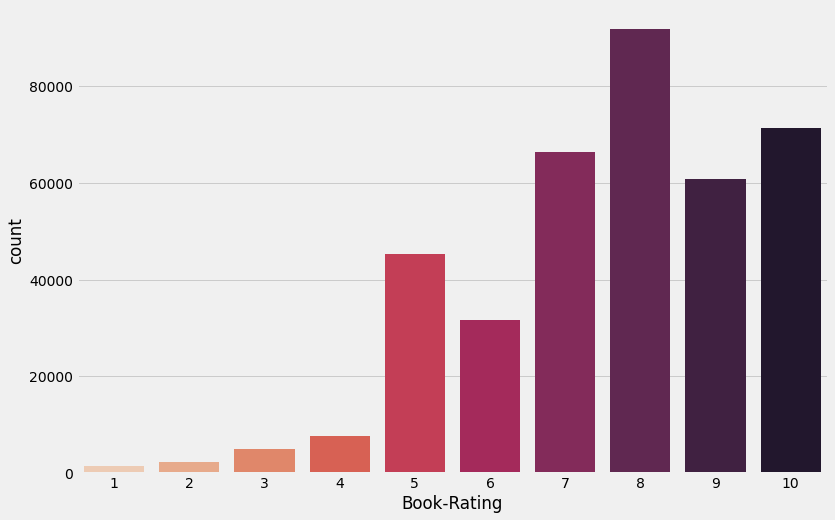

In [56]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings_explicit , x='Book-Rating', palette='rocket_r')

<font color='blue'>It can be observe that higher ratings are more common amongst users and rating 8 has been rated highest number of times

<font color= 'blue'>Let's find the top 5 books which are rated by most number of users.

In [57]:

rating_count = pd.DataFrame(ratings_explicit.groupby('ISBN')['Book-Rating'].count())
rating_count.sort_values('Book-Rating', ascending=False).head()

,Book-Rating
ISBN,
0316666343,707
0971880107,581
0385504209,487
0312195516,383
0060928336,320


<font color= 'blue'>The book with ISBN '0316666343' received the most rating counts. Let’s find out what book it is, and what books are in the top 5.

In [58]:
most_rated_books = pd.DataFrame(['0316666343', '0971880107', '0385504209', '0312195516', '0060928336'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
1,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far
2,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday
3,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA
4,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial


<font color= 'blue'>The book that received the most rating counts in this data set is Rich Shapero’s “Wild Animus”. And there is something in common among these five books that received the most rating counts — they are all novels. So it is conclusive that novels are popular and likely receive more ratings. 

In [59]:
most_rated_books = pd.DataFrame(['0316666343', '0971880107', '0385504209', '0312195516', '0060928336'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
1,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far
2,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday
3,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA
4,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial


<font color= 'blue'>The book that received the most rating counts in this data set is Rich Shapero’s “Wild Animus”. And there is something in common among these five books that received the most rating counts — they are all novels. So it is conclusive that novels are popular and likely receive more ratings. 

In [60]:
# Create column Rating average 
ratings_explicit['Avg_Rating']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Rating sum
ratings_explicit['Total_No_Of_Users_Rated']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('count')

In [61]:

ratings_explicit.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
1,276726,0155061224,5,5.000000,1
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
8,276744,038550120X,7,7.580247,81
16,276747,0060517794,9,8.000000,30


####<font color='blue'>**Merging All Dataset.**

In [62]:
df=users.copy()
df=pd.merge(df,ratings_explicit,on='User-ID')
df=pd.merge(df,books,on='ISBN')

In [63]:
df.head()

,User-ID,Age,Country,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,8,33.0,canada,0002005018,5,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
1,11676,28.0,nan,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,67544,30.0,canada,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,116866,32.0,other,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
4,123629,33.0,canada,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada


In [64]:
#Filling Nan of country with others
df['Country']=np.where(df['Country']=="nan","other",df["Country"])

In [65]:
df["Country"].isna().sum()

0

<h3><b>Data Visualization

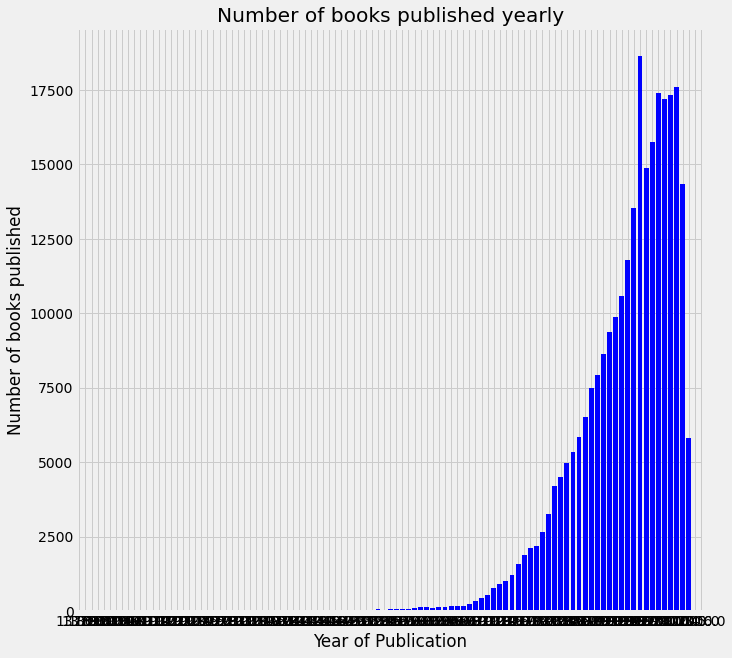

In [66]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(10, 10))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'No of books by an author (Top 15)')

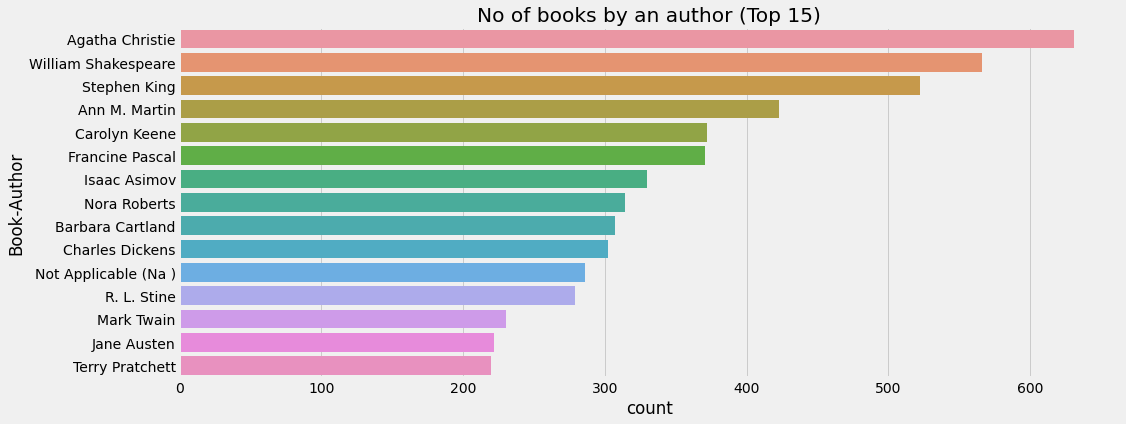

In [67]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

Text(0.5, 1.0, 'No of books published by a publisher (Top 15)')

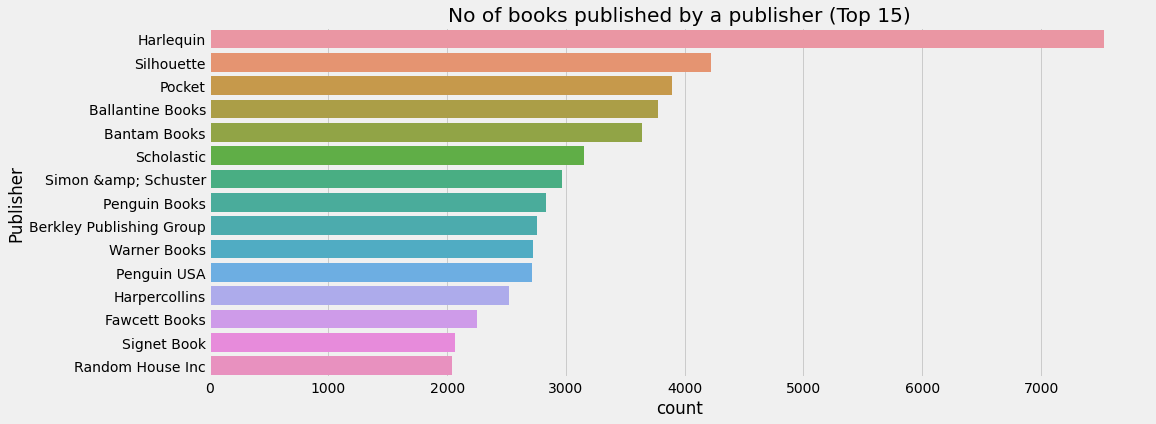

In [68]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("No of books published by a publisher (Top 15)")

Text(0.5, 1.0, 'Explicit Ratings')

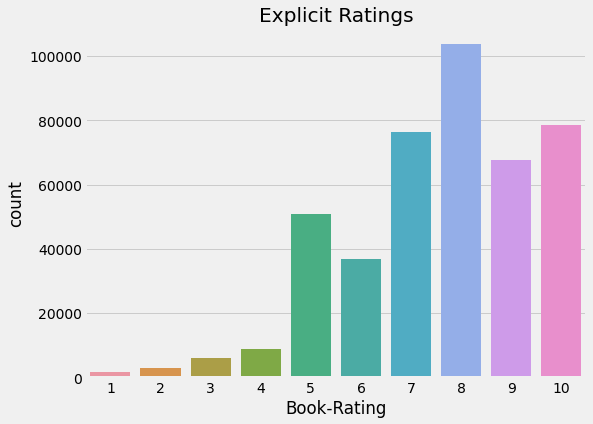

In [69]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

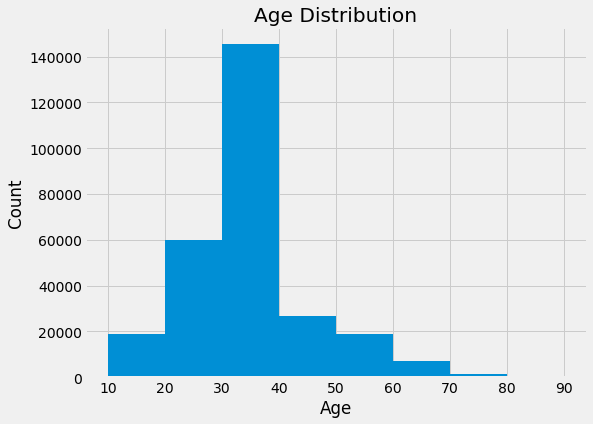

In [70]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [71]:
df.head()

,User-ID,Age,Country,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,8,33.0,canada,0002005018,5,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
1,11676,28.0,other,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,67544,30.0,canada,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,116866,32.0,other,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
4,123629,33.0,canada,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada


Text(0.5, 1.0, 'No of readers from each country (Top 10)')

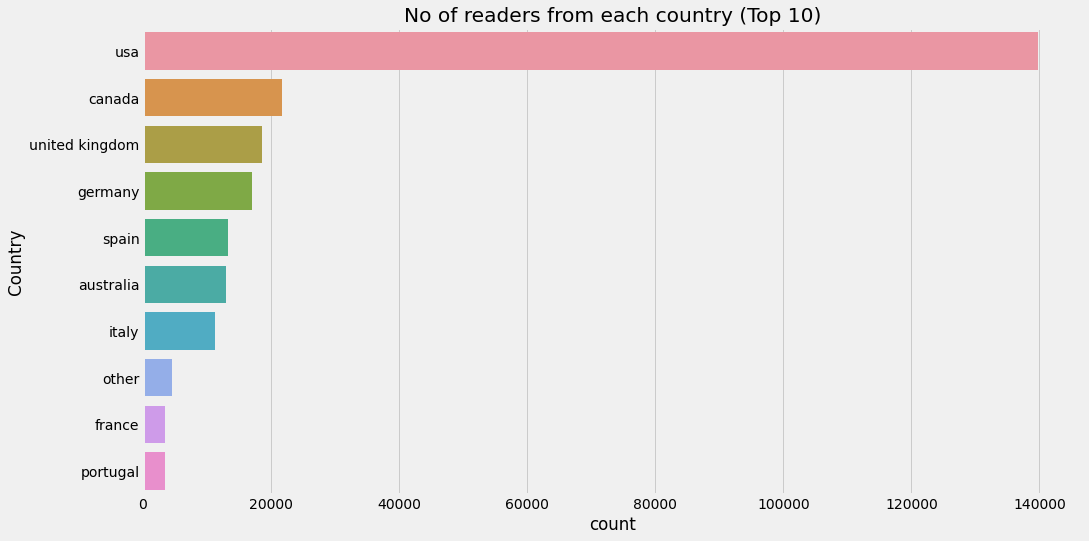

In [72]:
plt.figure(figsize=(15,8))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

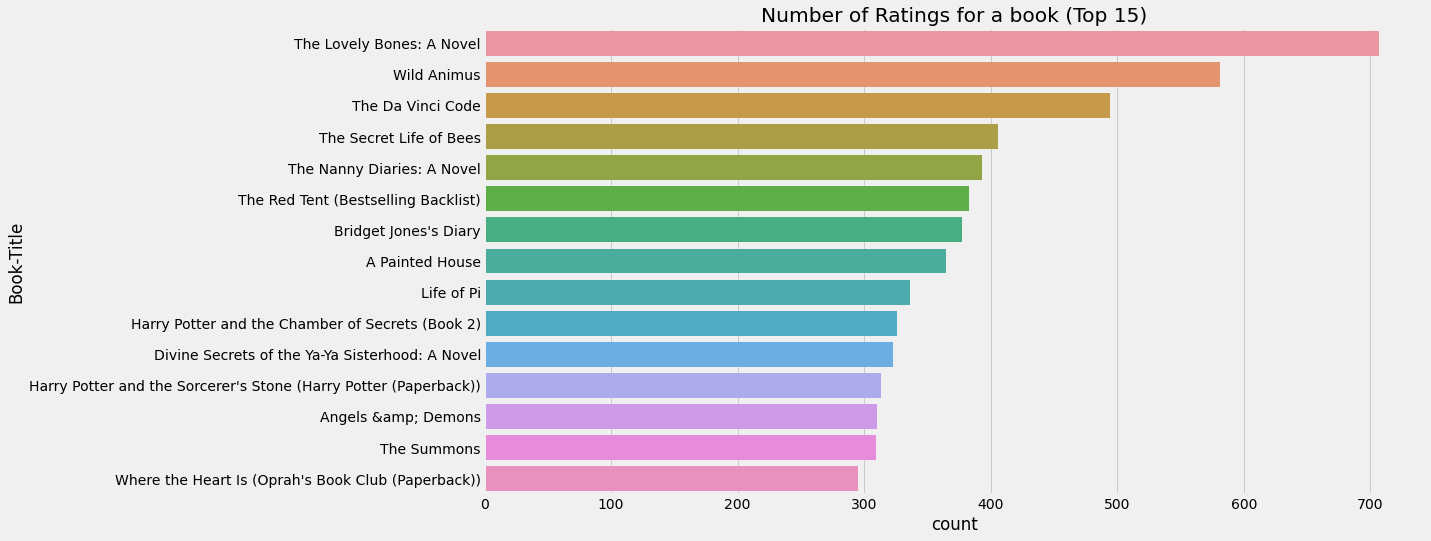

In [73]:

plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=df, order=df['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

#<font color='blue'>**Popularity Based Filtering**

<font color='blue'>As the name suggests Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any book which is usually bought by every new user then there are chances that it may suggest that book to the user who just signed up.<br>
Book weighted avg formula:<br>
Weighted Rating(WR)=[vR/(v+m)]+[mC/(v+m)]<br>
where,<br>
v is the number of votes for the books;<br>
m is the minimum votes required to be listed in the chart;<br>
R is the average rating of the book; and<br>
C is the mean vote across the whole report.<br>
Now we find the values of v,m,R,C.

In [74]:
C= df['Avg_Rating'].mean()
m= df['Total_No_Of_Users_Rated'].quantile(0.90)
Top_Books = df.loc[df['Total_No_Of_Users_Rated'] >= m]
print(f'C={C} , m={m}')
Top_Books.shape

C=7.626719799422565 , m=65.0


(38378, 11)

<font color='blue'>Here we used 90th percentile as our cutoff. In other words, for a book to feature in the charts, it must have more votes than at least 90% of the books in the list.<br>
We see that there are 38570 books which qualify to be in this list. Now, we need to calculate our metric for each qualified book. To do this, we will define a function, weighted_rating() and define a new feature score, of which we’ll calculate the value by applying this function to our DataFrame of qualified books:


In [75]:
def weighted_rating(x, m=m, C=C):
    v = x['Total_No_Of_Users_Rated']
    R = x['Avg_Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)
    
 
Top_Books['Score'] = Top_Books.apply(weighted_rating,axis=1)
 
 
#Sorting books based on score calculated above
Top_Books = Top_Books.sort_values('Score', ascending=False)

In [76]:
#Keeping only one entry of each book
Top_Books=Top_Books.sort_values('Score', ascending=False).drop_duplicates('ISBN').sort_index()
cm=sns.light_palette('yellow',as_cmap=True)
#Sorting books based on score calculated above
Top_Books = Top_Books.sort_values('Score', ascending=False)

#Printing the top 20 books
Top_Books[['Book-Title', 'Total_No_Of_Users_Rated', 'Avg_Rating', 'Score']].reset_index(drop=True).head(20).style.background_gradient(cmap=cm)

,Book-Title,Total_No_Of_Users_Rated,Avg_Rating,Score
0,Harry Potter and the Goblet of Fire (Book 4),137,9.262774,8.736321
1,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),313,8.939297,8.713589
2,Harry Potter and the Order of the Phoenix (Book 5),206,9.033981,8.696446
3,To Kill a Mockingbird,214,8.943925,8.637049
4,Harry Potter and the Prisoner of Azkaban (Book 3),133,9.082707,8.604731
5,Harry Potter and the Prisoner of Azkaban (Book 3),141,9.035461,8.590955
6,"The Return of the King (The Lord of the Rings, Part 3)",77,9.402597,8.589696
7,Harry Potter and the Sorcerer's Stone (Book 1),119,8.983193,8.504004
8,Harry Potter and the Chamber of Secrets (Book 2),189,8.783069,8.487153
9,Harry Potter and the Chamber of Secrets (Book 2),126,8.920635,8.480297


<font color='blue'>The Popularity based recommender provide a general chart of recommended books to all the users. They are not sensitive to the interests and tastes of a particular user.

#Content Based Filtering

In [77]:
data = pd.DataFrame(df.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
##data = pd.merge(data, books, on='ISBN', left_index = True)

In [78]:
dataset = pd.merge(books, data, on='ISBN', how='inner')

In [79]:
dataset.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,9
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,2
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,6
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,17
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,1


In [80]:
dataset["Book-Rating"].unique()

array([  9,   2,   6,  17,   1,   3, 169,  79,  13,   8, 581, 195,  14,
       214, 120,  24,  12,  36,  72,  71,  33,  20,  48, 133,   4,   7,
       194, 101,  62,  42,  32,  11, 243, 107,  55,  87,  34, 242, 104,
        10,  16, 269,  15,  95,   5,  41, 186,  22,  58,  18,  27,  23,
        30,  97,  53,  59,  98,  46,  67,  49,  63,  61,  89,  39,  74,
        85,  51,  25, 278,  93,  77, 156,  94,  65,  66,  92,  31,  19,
        26,  45,  21, 307,  91,  29,  57, 707,  44, 145, 217, 134, 155,
       117,  52, 383, 226,  60,  54,  28,  56, 143,  43, 154,  35, 116,
        90, 295, 165, 129, 487,  40,  83, 113, 159,  38,  47,  50, 150,
       127,  37, 138, 320, 207,  70,  81,  68, 151, 166, 200, 126,  73,
        86, 163, 131, 218,  82, 181,  69, 183, 106, 236, 144,  64,  78,
       108, 130, 105,  88, 177, 111,  75,  99, 164, 102, 136, 174, 230,
       100, 115, 206, 158, 119, 167, 132,  80, 153, 118, 103, 152, 161,
       189, 141,  76, 109,  96, 171, 229, 112, 272,  84, 139, 13

In [84]:
dataset["Book-Rating"].mean()

2.5645012562142515

Selecting books with total ratings equals to or more than 2 (Because of availability of limited resources)

In [85]:
popularity_threshold = 2
popular_book = dataset[dataset['Book-Rating'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(50408, 6)

In [86]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(50408, 121700)

In [87]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(50408, 50408)

In [88]:
cosine_similarities

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.9999999 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.9999999 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.99999994]], dtype=float32)

In [89]:
#bookName = input("Enter a book name: ")
#number = int(input("Enter number of books to recommend: "))

# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

In [90]:
bookName="Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"
number = int(10)

In [91]:
print("Recommended Books:\n")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:

Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Sorcerer's Stone (Book 1 Audio CD)
Harry Potter and the Sorcerer's Stone: A Deluxe Pop-up Book
Harry Potter and the Chamber of Secrets (Harry Potter)
Harry Potter and the Sorcerer's Stone Movie Poster Book
Harry Potter and the Prisoner of Azkaban (Harry Potter)
We Love Harry Potter!
Harry Potter, tome 1 : Harry Potter Ã?Â  l'Ã?Â©cole des sorciers
Harry Potter, tome 4 : Harry Potter et la coupe de feu
Harry Potter and the Philosopher's Stone


#<font color='blue'>**Model Based Collaborative Filtering Recommender**
<font color='blue'>The goal of the recommender system is to predict user preference for a set of items based on the past experience. Two the most popular approaches are Content-Based and Collaborative Filtering.
<br>Collaborative filtering is a technique used by websites like Amazon, YouTube, and Netflix. It filters out items that a user might like on the basis of reactions of similar users. There are two categories of collaborative filtering algorithms: memory based and model based.
<br>
Model based approach involves building machine learning algorithms to predict user's ratings. They involve dimensionality reduction methods that reduce high dimensional matrix containing abundant number of missing values with a much smaller matrix in lower-dimensional space.
<br>
The goal of this section is to compare SVD and NMF algorithms, try different configurations of parameters and explore obtained results.

In [92]:
import scipy
import math
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

<font color='blue'>This analysis will focus on book recommendations based on Book-Crossing dataset. To reduce the dimensionality of the dataset and avoid running into memory error we will focus on users with at least 3 ratings and top 10% most frequently rated books. 
<br>
The recommender systems will be built using surprise package (Matrix Factorization - based models).

In [93]:
ratings_explicit.rename(columns = {'User-ID':'user_id' ,'ISBN':'isbn' ,'Book-Rating':'book_rating'},inplace=True)

In [94]:
user_ratings_threshold = 3

filter_users = ratings_explicit['user_id'].value_counts()
filter_users_list = filter_users[filter_users >= user_ratings_threshold].index.to_list()

df_ratings_top = ratings_explicit[ratings_explicit['user_id'].isin(filter_users_list)]

print('Filter: users with at least %d ratings\nNumber of records: %d' % (user_ratings_threshold, len(df_ratings_top)))

Filter: users with at least 3 ratings
Number of records: 327070


In [95]:
book_ratings_threshold_perc = 0.1
book_ratings_threshold = len(df_ratings_top['isbn'].unique()) * book_ratings_threshold_perc

filter_books_list = df_ratings_top['isbn'].value_counts().head(int(book_ratings_threshold)).index.to_list()
df_ratings_top = df_ratings_top[df_ratings_top['isbn'].isin(filter_books_list)]

print('Filter: top %d%% most frequently rated books\nNumber of records: %d' % (book_ratings_threshold_perc*100, len(df_ratings_top)))

Filter: top 10% most frequently rated books
Number of records: 160714


<font color='blue'>SVD and NMF models comparison<br>
Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.


In [96]:
pip install surprise

     |████████████████████████████████| 11.8 MB 28.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630169 sha256=7807e1c6aa0e37f566ce0df2039c7a686afcdbdd6167bf6cb0049fe733e38e24
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [97]:
from surprise import Dataset, Reader
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [98]:
df=df_ratings_top.copy()
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

In [99]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, data, cv=3)
pd.DataFrame(cv_results_svd).mean()

test_rmse     1.602053
test_mae      1.239834
fit_time     12.666258
test_time     1.088772
dtype: float64

In [100]:
model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=3)
pd.DataFrame(cv_results_nmf).mean()

test_rmse     2.619149
test_mae      2.236257
fit_time     17.458985
test_time     0.912988
dtype: float64

<font color='blue'>
It's clear that for the given dataset much better results can be obtained with SVD approach - both in terms of accuracy and training / testing time.

##<font color='blue'>**Optimisation of SVD algorithm**<br>
<font color='blue'>Grid Search Cross Validation computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. It's useful for finding the best configuration of parameters.
<br>
It is used to find the best setting of parameters:
<br>
n_factors - the number of factors<br>
n_epochs - the number of iteration of the SGD procedure<br>
lr_all - the learning rate for all parameters<br>
reg_all - the regularization term for all parameters<br>
As a result, regarding the majority of parameters, the default setting is the most optimal one. The improvement obtained with Grid Search is very small.

In [101]:
param_grid = {'n_factors': [80,100],
              'n_epochs': [5, 20],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.5934391417444493
{'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}



#<font color='blue'>Analysis of Collaborative Filtering model results
<font color='blue'>In this part, let's examine in detail the results obtained by the SVD model that provided the best RMSE score.

In [102]:
trainset, testset = train_test_split(data, test_size=0.2)

model = SVD(n_factors=80, n_epochs=20, lr_all=0.005, reg_all=0.2)
model.fit(trainset)
predictions = model.test(testset)

In [103]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])
df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)
df_pred.sample(5)

,user_id,isbn,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
28883,155014,0553250426,10.0,8.407914,False,8.0,1.592086
30513,48975,0446516538,4.0,5.878285,False,6.0,1.878285
12337,70585,1400031346,7.0,8.243666,False,8.0,1.243666
7150,27813,0671705091,10.0,8.171591,False,8.0,1.828409
24802,147839,0375421440,8.0,6.833707,False,7.0,1.166293


<font color='blue'>Distribution of actual and predicted ratings in the test set
According to the distribution of actual ratings of books in the test set, the biggest part of users give positive scores - between 7 and 10. The mode equals 8 but count of ratings 7, 9, 10 is also noticeable. The distribution of predicted ratings in the test set is visibly different. One more time, 8 is a mode but scores 7, 9 and 10 are clearly less frequent.
<br>
It shows that the recommender system is not perfect and it cannot reflect the real distribution of book ratings.

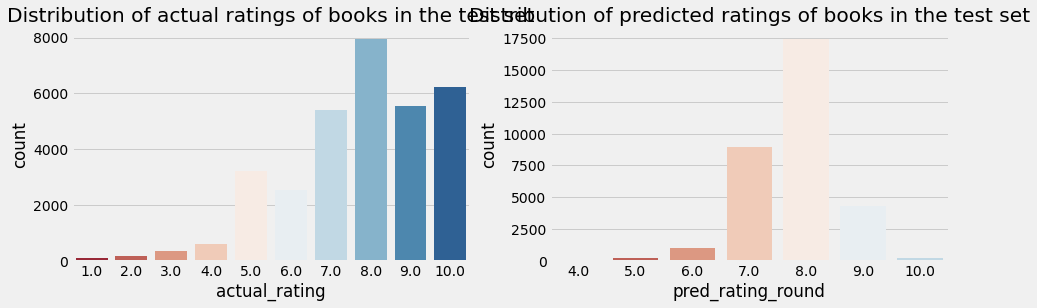

In [104]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

<font color='blue'>**Absolute error of predicted ratings**<br>
The distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 1. There is a long tail that indicates that there are several observations for which the absolute error was close to 10.
<br>
How good/bad the model is with predicting certain scores? As expected from the above charts, the model deals very well with predicting score = 8 (the most frequent value). The further the rating from score = 8, the higher the absolute error. The biggest errors happen to observations with scores 1 or 2 which indicates that probably the model is predicting high ratings for those observations.

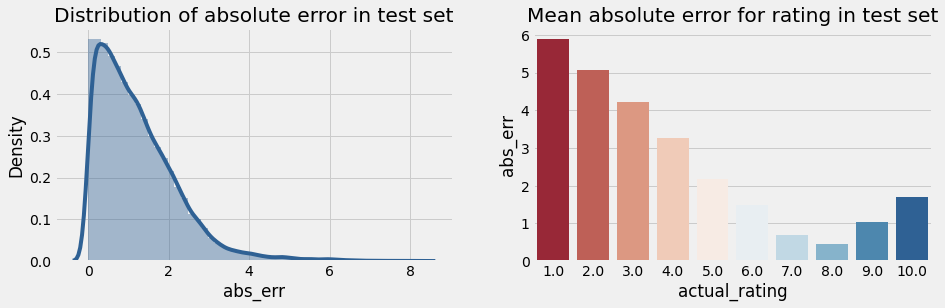

In [105]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

<font color='blue'>
Analysis of predicted ratings of a particular user<br>
For this part of the analysis, the user with id 193458 was selected. By analyzing book ratings by this user, it can be noted that he/she likes diverse types of readings: English romantic novels (Pride and Prejudice, Sense and Sensibility), fantasy (Narnia) as well as historical novels (Schindler's List). Among the recommended books there are other works from Narnia's series, two historical novels and one romance which correlates with user's previous preferences.

In [106]:
df_books = books.copy()
df_books.rename(columns = {'ISBN':'isbn' ,'Book-Title':'book_title'},inplace=True)
df_ext = df.merge(df_books[['isbn', 'book_title']], on='isbn', how='left')
df_ext = df_ext.merge(df_pred[['isbn', 'user_id', 'pred_rating']], on=['isbn', 'user_id'], how='left')

###<font color='blue'>Train set: Top rated books

In [107]:

selected_user_id = 193458
df_user = df_ext[df_ext['user_id']==selected_user_id]

df_user[(df_user['pred_rating'].isna())&(df_user['book_rating']>=9)].sample(10)

,user_id,isbn,book_rating,Avg_Rating,Total_No_Of_Users_Rated,book_title,pred_rating
113522,193458,0064471063,9,8.518519,27,The Horse and His Boy,NaN
113528,193458,0140298479,9,7.539823,113,Bridget Jones: The Edge of Reason,NaN
113525,193458,0064471098,9,8.733333,15,The Silver Chair,NaN
113537,193458,0345342569,9,7.947368,19,Shoeless Joe,NaN
113523,193458,0064471071,9,8.733333,15,The Voyage of the Dawn Treader (rack) (Narnia),NaN
113520,193458,0064471047,9,8.714286,42,"The Lion, the Witch, and the Wardrobe (The Chr...",NaN
113559,193458,0553258001,9,8.236842,38,The Cider House Rules,NaN
113536,193458,0330352695,9,7.615385,13,Four Letters of Love,NaN
113527,193458,014011369X,9,9.125000,8,"And the Band Played on: Politics, People, and ...",NaN
113566,193458,0789404257,9,9.000000,4,Eyewitness Travel Guide to Italy (revised),NaN



####<font color='blue'>Test set: predicted top rated books

In [108]:
df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(5)

,user_id,isbn,book_rating,Avg_Rating,Total_No_Of_Users_Rated,book_title,pred_rating
113531,193458,0142001740,9,8.452769,307,The Secret Life of Bees,8.517294
113546,193458,0399145923,6,7.833333,24,Carolina Moon,8.246441
113550,193458,0449006522,7,7.627451,51,Manhattan Hunt Club,7.915126
113570,193458,0887309100,9,7.600000,5,The Dilbert Future: Thriving on Business Stupi...,7.872112
113573,193458,185326007X,7,7.571429,7,Women in Love (Wordsworth Classics),7.757613


####<font color='blue'>Test set: actual top rated books

In [109]:
df_user[df_user['pred_rating'].notna()].sort_values('book_rating', ascending=False).head(5)

,user_id,isbn,book_rating,Avg_Rating,Total_No_Of_Users_Rated,book_title,pred_rating
113531,193458,0142001740,9,8.452769,307,The Secret Life of Bees,8.517294
113570,193458,0887309100,9,7.600000,5,The Dilbert Future: Thriving on Business Stupi...,7.872112
113544,193458,0385474016,8,7.440678,59,Like Water for Chocolate: A Novel in Monthly I...,7.418884
113553,193458,0449221873,8,7.000000,8,Mexico,7.578964
113548,193458,042518109X,7,7.666667,21,Whispers,7.665316


#<font color='blue'>Collaborative Filtering based Recommendation System--(Item-Item Based)

In [110]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import numpy as np
import os, sys
import re
from scipy.sparse import csr_matrix

In [111]:
df_ratings_top.head()

,user_id,isbn,book_rating,Avg_Rating,Total_No_Of_Users_Rated
16,276747,0060517794,9,8.000000,30
19,276747,0671537458,9,7.176471,17
20,276747,0679776818,8,7.476190,21
59,276772,0553572369,7,6.625000,8
61,276772,3499230933,10,7.166667,6


In [112]:
df_ratings_top.rename(columns={'user_id':'userID' ,'isbn':'ISBN','book_rating':'bookRating'},inplace=True)

In [113]:
df_ratings_top.head()

,userID,ISBN,bookRating,Avg_Rating,Total_No_Of_Users_Rated
16,276747,0060517794,9,8.000000,30
19,276747,0671537458,9,7.176471,17
20,276747,0679776818,8,7.476190,21
59,276772,0553572369,7,6.625000,8
61,276772,3499230933,10,7.166667,6


#<font color='blue'>Collaborative Filtering based Recommendation System--(User-Item based)

In [114]:
ratings_explicit.head()
ratings_explicit.rename(columns={'user_id':'User-ID','isbn':'ISBN','book_rating':'Book-Rating'},inplace=True)

In [115]:
ratings_explicit.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
1,276726,0155061224,5,5.000000,1
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
8,276744,038550120X,7,7.580247,81
16,276747,0060517794,9,8.000000,30


In [116]:

users_interactions_count_df = ratings_explicit.groupby(['ISBN', 'User-ID']).size().groupby('User-ID').size()
print('# of users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 100].reset_index()[['User-ID']]
print('# of users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# of users: 68080
# of users with at least 5 interactions: 449


In [117]:
print('# of interactions: %d' % len(ratings_explicit))
interactions_from_selected_users_df = ratings_explicit.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'User-ID',
               right_on = 'User-ID')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 383643
# of interactions from users with at least 5 interactions: 103218


In [118]:
interactions_from_selected_users_df.head(10)

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
0,2033,0030020786,7,7.000000,1
1,2033,0060248025,10,8.766667,30
2,2033,0060256664,10,8.333333,6
3,2033,0060256737,10,9.045455,22
4,2033,0060950536,10,9.400000,5
5,2033,0061020419,7,7.000000,1
6,2033,0061020427,6,6.000000,1
7,2033,0061056278,10,9.000000,2
8,2033,0061056286,8,7.666667,3
9,2033,0061056294,9,7.000000,2


In [119]:
import math

In [120]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df.groupby(['ISBN', 'User-ID'])['Book-Rating'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

# of unique user/item interactions: 103218


,ISBN,User-ID,Book-Rating
0,0000913154,171118,3.169925
1,0001046438,23902,3.321928
2,000104687X,23902,2.807355
3,0001047213,23902,3.321928
4,0001047973,23902,3.321928


In [121]:
from sklearn.model_selection import train_test_split

In [122]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['User-ID'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 82574
# interactions on Test set: 20644


In [123]:
interactions_test_df.head()

,ISBN,User-ID,Book-Rating
73264,0740718398,181176,3.169925
61853,0609607375,16795,3.169925
560,0028610105,106007,3.459432
32495,0393014894,123094,3.459432
1263,0060175400,95359,3.321928


In [124]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='User-ID', 
                                                          columns='ISBN', 
                                                          values='Book-Rating').fillna(0)

users_items_pivot_matrix_df.head()

ISBN,0000913154,000104687X,0001047973,000104799X,0001048082,0001053736,0001053744,0001056107,0001845039,0001935968,...,B00006CRTE,B00007FYKW,B00008RWPV,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000X8HIE,B0001I1KOG,B000234N3A
User-ID,,,,,,,,,,,,,,,,,,,,,
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[2033, 2110, 2276, 4017, 4385, 5582, 6242, 6251, 6543, 6575]

In [127]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [128]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [129]:
users_items_pivot_matrix.shape

(449, 55883)

In [130]:
U.shape

(449, 15)

In [131]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [132]:
Vt.shape

(15, 55883)

<font color='blue'>After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [133]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.01733077,  0.0027921 ,  0.00330388, ...,  0.0012938 ,
         0.00039019,  0.0087447 ],
       [ 0.00032903, -0.0006894 , -0.00081576, ...,  0.00041622,
         0.00015883,  0.00282784],
       [ 0.00459014, -0.00171395, -0.0020281 , ...,  0.00113719,
         0.00035406,  0.00714377],
       ...,
       [ 0.0047435 ,  0.00214978,  0.00254382, ...,  0.00096478,
         0.00049112,  0.00757833],
       [ 0.02816612, -0.00227859, -0.00269624, ...,  0.00128147,
         0.00072672,  0.01072866],
       [-0.00076533,  0.00225201,  0.00266479, ...,  0.00031609,
         0.00017691,  0.00269938]])

In [134]:
all_user_predicted_ratings.shape

(449, 55883)

In [135]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,2033,2110,2276,4017,4385,5582,6242,6251,6543,6575,...,269566,270713,271448,271705,273113,274061,274301,275970,277427,278418
ISBN,,,,,,,,,,,,,,,,,,,,,
0000913154,0.017331,0.000329,0.004590,0.001000,-0.001696,-0.003680,-0.003304,0.001354,0.011427,0.012453,...,-0.004465,-0.002720,-0.002441,0.001582,-0.009039,0.003749,0.014731,0.004744,0.028166,-0.000765
000104687X,0.002792,-0.000689,-0.001714,0.017308,-0.000550,0.008092,0.016928,0.006323,-0.002778,0.011584,...,-0.002434,0.013200,-0.001499,0.019831,-0.004529,-0.006056,0.016189,0.002150,-0.002279,0.002252
0001047973,0.003304,-0.000816,-0.002028,0.020481,-0.000651,0.009576,0.020031,0.007482,-0.003287,0.013707,...,-0.002880,0.015620,-0.001774,0.023465,-0.005359,-0.007166,0.019156,0.002544,-0.002696,0.002665
000104799X,0.000641,0.000243,0.000681,0.001612,0.000176,0.001203,0.001292,0.002642,0.001651,0.004085,...,0.001218,0.002340,0.002373,0.001287,0.001363,0.002147,0.001654,0.000799,0.001294,0.000267
0001048082,0.004278,-0.000256,-0.000606,0.021918,-0.000316,0.010934,0.020981,0.011628,-0.000686,0.019336,...,-0.000876,0.019079,0.002148,0.024733,-0.003194,-0.003077,0.021482,0.003627,-0.000592,0.003032


In [136]:
len(cf_preds_df.columns)

449

In [137]:
global books
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company


In [138]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df):
        self.cf_predictions_df = cf_predictions_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)
        recommendations_df=recommendations_df.merge(books,on='ISBN',how='inner')
        recommendations_df=recommendations_df[['ISBN','Book-Title','recStrength']]

        return recommendations_df



cf_recommender_model = CFRecommender(cf_preds_df)

In [139]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('User-ID')
interactions_train_indexed_df = interactions_train_df.set_index('User-ID')
interactions_test_indexed_df = interactions_test_df.set_index('User-ID')

In [140]:
def get_items_interacted(UserID, interactions_df):
    interacted_items = interactions_df.loc[UserID]['ISBN']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [141]:
class ModelRecommender:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(ratings_explicit['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)
        print('Recommendation for User-ID = ',person_id)
        print(person_recs_df.head(10))

        # Function to evaluate the performance of model at overall level
    def recommend_book(self, model ,userid):
        
        person_metrics = self.evaluate_model_for_user(model, userid)  
        return

model_recommender = ModelRecommender()    

<font color='blue'>**Let's recommend books to User-Id 69078 and see the results.**

In [142]:
print(list(interactions_full_indexed_df.index.values))

[171118, 23902, 23902, 23902, 23902, 166596, 23902, 109901, 189835, 189835, 85526, 93047, 95359, 56399, 229329, 11676, 69078, 63714, 101606, 11676, 36907, 85526, 26583, 120565, 101606, 11676, 193560, 262998, 23902, 63714, 11676, 159506, 189835, 11676, 180651, 63714, 193560, 274301, 120565, 30511, 189334, 189334, 275970, 166596, 23902, 6242, 101606, 101851, 11676, 95010, 11676, 37712, 123883, 94853, 23902, 23902, 11676, 189334, 11676, 11676, 149908, 30511, 94853, 225087, 172742, 120565, 16634, 88733, 218552, 264321, 189334, 56271, 11676, 63714, 6543, 30511, 134434, 76626, 240543, 26583, 248718, 76626, 56399, 270713, 168245, 168245, 98758, 23902, 63714, 107784, 37644, 37644, 168245, 164096, 35859, 177458, 136010, 197659, 23902, 11676, 11676, 23902, 78973, 200226, 30810, 11676, 242006, 225087, 11676, 274301, 11676, 30511, 193560, 189835, 39281, 120565, 11676, 183958, 11676, 148199, 23902, 109955, 76626, 193560, 148258, 11676, 63714, 85526, 109955, 23902, 225232, 148258, 189334, 105517, 62

In [143]:
user=int(input("Enter User ID from above list for book recommendation  "))
model_recommender.recommend_book(cf_recommender_model,user)

Enter User ID from above list for book recommendation  23902
Recommendation for User-ID =  23902
         ISBN                                     Book-Title  recStrength
0  1573229725                                    Fingersmith     0.143731
1  0374129983                                The Corrections     0.143227
2  0156027321                                     Life of Pi     0.141964
3  014029628X                          Girl in Hyacinth Blue     0.141417
4  067976402X                         Snow Falling on Cedars     0.132460
5  0452282152                      Girl with a Pearl Earring     0.129409
6  0446310786                          To Kill a Mockingbird     0.129142
7  0804106304                              The Joy Luck Club     0.127105
8  0312282990  The Amazing Adventures of Kavalier &amp; Clay     0.123689
9  0060958022                    Five Quarters of the Orange     0.118620


# <font color='blue'> **Evaluate**
### <font color='blue'>In Recommender Systems, there are a set metrics commonly used for evaluation. We choose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

### <font color='blue'>This evaluation method works as follows:

* ### <font color='blue'>For each user
    * ### <font color='blue'>For each item the user has interacted in test set
        * ### <font color='blue'>Sample 100 other items the user has never interacted.   
        * ### <font color='blue'> Ask the recommender model to produce a ranked list of recommended items, from a set composed of one interacted item and the 100 non-interacted items
        * ### <font color='blue'>Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* ### <font color='blue'> Aggregate the global Top-N accuracy metrics

In [144]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(ratings_explicit['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id)    #%(2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ISBN'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['User-ID'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [145]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
448 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.23953691145126912, 'recall@10': 0.3069172640961054}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,User-ID
6,261,336,1388,0.188040,0.242075,11676
13,177,239,1138,0.155536,0.210018,98391
130,17,24,380,0.044737,0.063158,189835
32,102,116,369,0.276423,0.314363,153662
49,28,35,236,0.118644,0.148305,23902
154,30,47,204,0.147059,0.230392,235105
15,15,22,202,0.074257,0.108911,76499
1,55,68,192,0.286458,0.354167,16795
182,36,46,192,0.187500,0.239583,171118
129,20,32,188,0.106383,0.170213,248718


#<font color='blue'>**Conclusion**
<font color='blue'>

* In EDA, the Top-10 most rated books were essentially **novels**. Books like **The 
Lovely Bone** and **The Secret Life of Bees** were very well perceived.<br>
* Majority of the readers were of the **age bracket 20-35** and most of them came from North American and European countries namely **USA, Canada, UK, Germany and Spain**.<br>
* If we look at the ratings distribution, **most of the books have high ratings** with maximum books being rated 8. Ratings below 5 are few in number.<br>
* Author with the most books was **Agatha Christie, William Shakespeare and Stephen King**.<br>
* For modelling, it was observed that for **model based** collaborative filtering SVD technique worked way better than NMF with lower Mean Absolute Error (MAE) .<br>
* Amongst the memory based approach, **item-item CF performed better** than **user-user CF** because of lower computation  .

